In [ ]:
!pip install -q datasets
!pip install -q open_clip_torch
!pip install -q torch
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import open_clip
import torch
import transformers
from sklearn import metrics
from datasets import load_dataset
import scipy
import warnings
warnings.filterwarnings('ignore')

In [ ]:
dataset = load_dataset('poloclub/diffusiondb', '2m_first_10k')
df = dataset['train'].to_pandas()
df.drop_duplicates(subset=['prompt'], inplace=True)
df['image'] = df['image'].apply(lambda x: x['path'])

df = df.sample(n=2000, random_state=42).reset_index(drop=True)

df.reset_index(inplace=True, drop=True)

df.head(2)

Generating train split: 0 examples [00:00, ? examples/s]

Dataset diffusiondb downloaded and prepared to /root/.cache/huggingface/datasets/poloclub___diffusiondb/2m_first_10k/0.9.1/547894e3a57aa647ead68c9faf148324098f47f2bc1ab6705d670721de9d89d1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

,image,prompt,seed,step,cfg,sampler,width,height,user_name,timestamp,image_nsfw,prompt_nsfw
0,/root/.cache/huggingface/datasets/downloads/ex...,"classic oil painting, sci fi beautiful landsca...",3578732311,50,12.0,k_lms,1280,512,26da12cd3526e1b10319bb5d94ea516909c1cb4a5b77da...,2022-08-18 20:28:00+00:00,0.059204,0.000319
1,/root/.cache/huggingface/datasets/downloads/ex...,"3 panel scene, anime girl sleeps inside a cozy...",1787203390,50,5.0,k_lms,512,1024,56b9f823a65b1259d7a469d0e0726722e6f87297384c8f...,2022-08-20 02:43:00+00:00,0.183237,0.000596


In [ ]:
df.shape

(2000, 12)

In [ ]:
labels = pd.read_csv('labels.csv')
df = df.merge(labels, on='prompt', how='inner')
df.head(1)

,image,prompt,seed,step,cfg,sampler,width,height,user_name,timestamp,...,phrase_1,phrase_2,phrase_3,phrase_4,phrase_5,phrase_6,phrase_7,first_seven,cs_prompt_open,cs_prompt_seven
0,/root/.cache/huggingface/datasets/downloads/ex...,"classic oil painting, sci fi beautiful landsca...",3578732311,50,12.0,k_lms,1280,512,26da12cd3526e1b10319bb5d94ea516909c1cb4a5b77da...,2022-08-18 20:28:00+00:00,...,a man standing on a rock in a mountain valley,8 k matte painting,8k matte painting,matte fantasy painting,4 k matte painting,luminescent matte painting,high fantasy matte painting,a man standing on rock in mountain valley 8 k ...,0.392391,0.330291


In [ ]:
labels.head(1)

,prompt,open_clip,clip_inter,phrase_1,phrase_2,phrase_3,phrase_4,phrase_5,phrase_6,phrase_7,first_seven,cs_prompt_open,cs_prompt_seven
0,"classic oil painting, sci fi beautiful landsca...",a painting of a mountain range with a body of ...,['a man standing on a rock in a mountain valle...,a man standing on a rock in a mountain valley,8 k matte painting,8k matte painting,matte fantasy painting,4 k matte painting,luminescent matte painting,high fantasy matte painting,a man standing on rock in mountain valley 8 k ...,0.392391,0.330291


## Column Explanations

| column | meaning |
| --- | --- |
| open_clip | open clip response |
| clip_inter | clip interrogator full response, list format |
| phrase_1 | first phrase from clip interrogator |
| phrase_2 | second phrase from clip interrogator |
| phrase_3 | third phrase from clip interrogator |
| phrase_4 | fourth phrase from clip interrogator |
| phrase_5 | fifth phrase from clip interrogator |
| phrase_6 | sixth phrase from clip interrogator |
| phrase_7 | seventh phrase from clip interrogator |
|first_seven | all 7 phrase concatenated as a string, dropped duplicate words |
| cs_prompt_open | cosine similarity of original prompt and open clip response |
| cs_prompt_seven | cosine similarity of prompt and "first_seven" of clip interrogator|



## Test Train Split

In [ ]:
train = df.iloc[0:1500]
test = df.iloc[1500:2000]

train.shape, test.shape

((1500, 24), (500, 24))

In [ ]:
train.head(1)

,image,prompt,seed,step,cfg,sampler,width,height,user_name,timestamp,...,phrase_1,phrase_2,phrase_3,phrase_4,phrase_5,phrase_6,phrase_7,first_seven,cs_prompt_open,cs_prompt_seven
0,/root/.cache/huggingface/datasets/downloads/ex...,"classic oil painting, sci fi beautiful landsca...",3578732311,50,12.0,k_lms,1280,512,26da12cd3526e1b10319bb5d94ea516909c1cb4a5b77da...,2022-08-18 20:28:00+00:00,...,a man standing on a rock in a mountain valley,8 k matte painting,8k matte painting,matte fantasy painting,4 k matte painting,luminescent matte painting,high fantasy matte painting,a man standing on rock in mountain valley 8 k ...,0.392391,0.330291


In [ ]:
test.head(1)

,image,prompt,seed,step,cfg,sampler,width,height,user_name,timestamp,...,phrase_1,phrase_2,phrase_3,phrase_4,phrase_5,phrase_6,phrase_7,first_seven,cs_prompt_open,cs_prompt_seven
1500,/root/.cache/huggingface/datasets/downloads/ex...,"lemonbrat studios bat fursuit, fursuiter, cand...",1758474385,50,10.0,k_lms,512,640,eaa41f839ff05c773bb8a0907424edbfeedf3ae4ccce84...,2022-08-16 19:17:00+00:00,...,a person in a costume with a cat mask on,fursuit,fursuit!!!!,furry character portrait,headshot of young female furry,furry character,macro furry,a person in costume with cat mask on fursuit f...,0.228366,0.474969


[ full - body portrait of a man ]! with a disdain, exacerbated facial expression, wearing a [ white robe ]!, trending on [ artstation ]!, digital art, cgsociety contest winner, [ symmetrical ]!, golden ratio!, award winning, bioluminescent colors, volumetric lighting, afrofuturism 


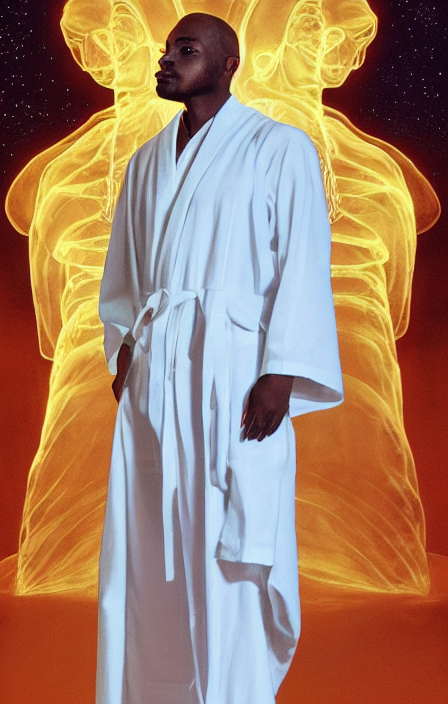

In [ ]:
nums = np.random.randint(0, 1500, 1)

for i in nums :
    img = Image.open(train['image'][i])
    prompt = train['prompt'][i]
    print(prompt)
    display(img)

## Yolo

In [ ]:
# YOLOv5 PyTorch HUB Inference (DetectionModels only)

model = torch.hub.load('ultralytics/yolov5', 'yolov5l', force_reload=True)  # yolov5n - yolov5x6 or custom
#im = 'https://ultralytics.com/images/zidane.jpg'  # file, Path, PIL.Image, OpenCV, nparray, list  # or .show(), .save(), .crop(), .pandas(), etc.

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: YOLOv5 requirements "gitpython>=3.1.30" "setuptools>=65.5.1" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.6 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 63.4.3
    Uninstalling setuptools-63.4.3:
      Successfully uninstalled setuptools-63.4.3

requirements: 2 packages updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2023-3-17 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)



  0%|          | 0.00/89.3M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5l summary: 367 layers, 46533693 parameters, 0 gradients
Adding AutoShape... 


1


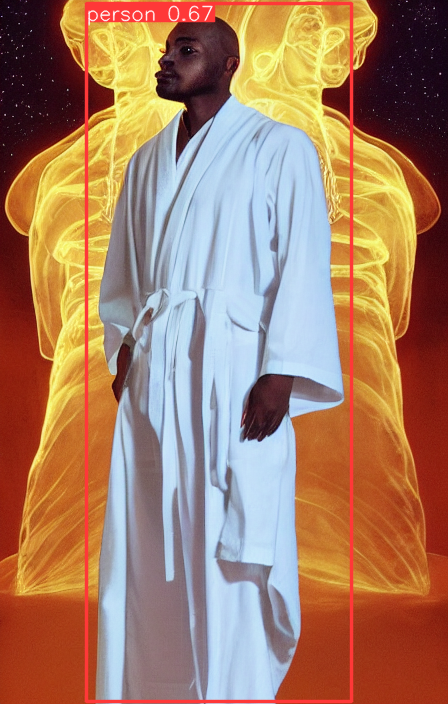

In [ ]:
results = model(img)  # inference
print(len(results.pandas().xyxy[0]))
results.show()

## Open Clip

In [ ]:
open_model, _, transform = open_clip.create_model_and_transforms(
  model_name="coca_ViT-L-14",
  pretrained="mscoco_finetuned_laion2B-s13B-b90k"
)

In [ ]:
count = 0
cropped = 0
results_df = pd.DataFrame(columns=['prompt', 'quad_1', 'quad_2', 'quad_3', 'quad_4', 'yolo'])

for index, row in test.iterrows() :

    image = Image.open(row['image'])
    prompt = row['prompt']

    results = model(image) 

    # split image into 4 quadrants
    width, height = image.size
    left = 0
    top = 0
    right = width / 2
    bottom = height / 2

    # crop image
    image1 = image.crop((left, top, right, bottom))
    image2 = image.crop((right, top, width, bottom))
    image3 = image.crop((left, bottom, right, height))
    image4 = image.crop((right, bottom, width, height))
    cropped += 1

    prompts = []
    for picture in [image1, image2, image3, image4] :

      im = picture.convert("RGB")
      im = transform(im).unsqueeze(0)

      with torch.no_grad(), torch.cuda.amp.autocast():
        generated = open_model.generate(im)

      clip = open_clip.decode(generated[0]).split("<end_of_text>")[0].replace("<start_of_text>", "")
      prompts.append(clip)

    results_df = results_df.append({'prompt': prompt, 'quad_1': prompts[0], \
                  'quad_2': prompts[1], 'quad_3': prompts[2], 'quad_4': prompts[3], \
                  'yolo': len(results.pandas().xyxy[0])}, ignore_index=True) 
      


    count += 1
    if count % 10 == 0 :
      print(count)
      print(cropped)

10
10
20
20
30
30
40
40
50
50
60
60
70
70
80
80
90
90
100
100
110
110
120
120
130
130
140
140
150
150
160
160
170
170
180
180
190
190
200
200
210
210
220
220
230
230
240
240
250
250
260
260
270
270
280
280
290
290
300
300
310
310
320
320
330
330
340
340
350
350
360
360
370
370
380
380
390
390
400
400
410
410
420
420
430
430
440
440
450
450
460
460
470
470
480
480
490
490
500
500


In [ ]:
results_df

,prompt,quad_1,quad_2,quad_3,quad_4,yolo,quad_2_oc
0,"lemonbrat studios bat fursuit, fursuiter, cand...",a close - up view of a yellow and black bird .,NaN,a close up of a stuffed animal wearing a costu...,a close - up view of a purple and yellow wig .,1,a close - up view of a purple and yellow flowe...
1,"a raspberry made of metal, reflective, unreal ...",a close up of some raspberries on a table .,NaN,a close - up of two raspberries on a table .,a person holding onto a balloon in the sky .,0,a close up of a raspberry on a table .
2,"🐉🌊 digital artwork by vincent bons, michael wh...",an abstract painting of a boat in the water .,NaN,an oil painting of a sailboat in the ocean .,a painting of a boat in the water,0,an image of a woman in a green dress
3,"bridge to the light, beautiful landscape, envi...",a person sitting on top of a boat on a pier .,NaN,an artistic painting of a tree trunk in the mi...,an artistic painting of a bridge over a body o...,0,the sun is setting on a cloudy day .
4,"graffiti explosion, multicolor color scheme, b...",an abstract painting of a bunch of different t...,NaN,an oil painting of a pile of trash .,an oil painting of a pile of trash .,0,an abstract painting of a sky filled with lots...
...,...,...,...,...,...,...,...
495,"a small ocean full of life, studio lighting, g...",the sun is shining on a cloudy sky .,NaN,a person standing in the water next to the oce...,a large body of water that is very dark .,1,the sun is shining on the surface of the water .
496,an sem photo of a corgi,an orange and white cat is looking up at the s...,NaN,a close - up of the face of a dog with its mou...,a close - up of the face of a corgi dog .,2,an orange and white cat is looking at the came...
497,photo cartoon illustration painting of small s...,a painting of a room with neon lights .,NaN,an artistic painting of a city street filled w...,a painting of a room with a lot of furniture .,1,an abstract painting of a building and stairs .
498,a beautiful close - up of of a blond german ma...,a close - up view of the face of a woman with ...,NaN,a close - up view of a man 's torso and arms .,a close - up view of a man 's lips .,1,a close - up view of a man 's eyes .


In [ ]:
results_df.rename(columns={'quad_2_oc': 'quad_2'}).to_csv('open_yolo.csv', index=False)

In [ ]:
results_df.to_csv('open_yolo.csv', index=False)